In [1]:
import timeit
import warnings

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [6]:
t0 = timeit.default_timer()

# We use SAGA solver
solver = 'saga'

# Turn down for faster run time
n_samples = 10000

X, y = fetch_20newsgroups_vectorized(subset='all', return_X_y=True)
X = X[:n_samples]
y = y[:n_samples]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.1)
train_samples, n_features = X_train.shape
n_classes = np.unique(y).shape[0]

print('Dataset 20newsgroup, train_samples=%i, n_features=%i, n_classes=%i'
      % (train_samples, n_features, n_classes))

models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 2, 4]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}

print(y_train[:10])

Dataset 20newsgroup, train_samples=9000, n_features=130107, n_classes=20
[ 2  9 13 11 15 18 19 17  6  3]


In [3]:

for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                penalty='l1',
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = timeit.default_timer()
        lr.fit(X_train, y_train)
        train_time = timeit.default_timer() - t1

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        accuracies.append(accuracy)
        densities.append(density)
        times.append(train_time)
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies
    print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    print('%% non-zero coefficients for model %s, '
          'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for model %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))


[model=One versus Rest, solver=saga] Number of epochs: 1
[model=One versus Rest, solver=saga] Number of epochs: 2
[model=One versus Rest, solver=saga] Number of epochs: 4
Test accuracy for model ovr: 0.7490
% non-zero coefficients for model ovr, per class:
 [0.31743104 0.36815852 0.4181174  0.46115889 0.24595141 0.41350581
 0.31281945 0.27054655 0.58720899 0.32972861 0.4158116  0.3312658
 0.41888599 0.41120001 0.59643217 0.31666244 0.34279478 0.28130692
 0.35278655 0.24748861]
Run time (4 epochs) for model ovr:8.84
[model=Multinomial, solver=saga] Number of epochs: 1
[model=Multinomial, solver=saga] Number of epochs: 3
[model=Multinomial, solver=saga] Number of epochs: 7
Test accuracy for model multinomial: 0.7450
% non-zero coefficients for model multinomial, per class:
 [0.13219888 0.11452112 0.13066169 0.13681047 0.12066991 0.15909982
 0.13450468 0.09146318 0.07916561 0.12143851 0.13911627 0.10760374
 0.18984374 0.12143851 0.17524038 0.22289346 0.11605832 0.07916561
 0.07301682 0.15

Example run in 333.803 s


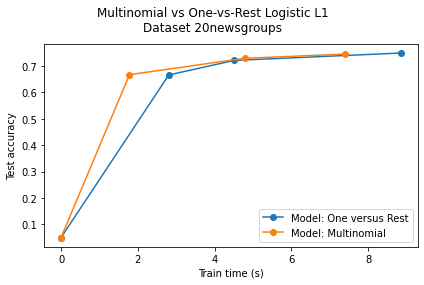

In [4]:

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = timeit.default_timer() - t0
print('Example run in %.3f s' % run_time)
plt.show()